In [1]:
import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell as LSTM
from tensorflow.contrib.rnn import LSTMStateTuple as LSTMState
import numpy as np

In [2]:
PERIODS = [1, 2, 4, 8, 16, 32, 64, 128]

In [3]:
class LatentLSTM(LSTM):
    def __init__(self, batch_size, latency, num_of_units, **args):
        LSTM.__init__(self, num_of_units, args)
        self.latency = max(1, latency)
        self.time = 0
        
        self.states = [tf.contrib.rnn.LSTMStateTuple(
            tf.Variable(np.zeros((batch_size, num_of_units)), dtype=tf.float32),
            tf.Variable(np.zeros((batch_size, num_of_units)), dtype=tf.float32)) for _ in range(self.latency)]
        
    def __call__(self, inputs, state, scope=None):        
        output, newstate = LSTM.__call__(self, inputs, state, scope)
        tf.assign(self.states[self.time][0], newstate[0])
        tf.assign(self.states[self.time][1], newstate[1])
        self.time = (self.time + 1) % self.latency
        return output, newstate

In [166]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.01
batch_size = 125

# Network Parameters
num_input = 16       # dimension of one input at moment
num_hidden = 32     # num of lstms in first hidden layer
num_output = 16      # output dimension

# tf graph input
X = tf.placeholder("float", [batch_size, 512, num_input])
_X = tf.unstack(X, 512, 1)

capsules = []
memories = []
memories2 = []
for p in PERIODS:
    with tf.variable_scope("capsule1" + str(p)):
        multirnn = tf.nn.rnn_cell.MultiRNNCell([
                                LatentLSTM(batch_size, p, num_hidden, forget_bias=1.0)
                                              ])
        outp, m = tf.nn.dynamic_rnn(cell=multirnn, inputs=X[:, :-1], dtype=tf.float32)
        memories.append(m)
        
    with tf.variable_scope("capsule2" + str(p)):    
        multirnn = tf.nn.rnn_cell.MultiRNNCell([
                                LatentLSTM(batch_size, p - 1, num_hidden, forget_bias=1.0)
                                              ])
        outp2, m = tf.nn.dynamic_rnn(cell=multirnn, inputs=tf.concat([outp, X[:, :-1]], axis=2), dtype=tf.float32)
        memories2.append(m)
        
        capsules.append(outp2)

lstm_outputs = tf.concat(capsules, axis=2)

ans = tf.layers.dense(lstm_outputs, num_output, activation=None)

ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=ans[:, 64:], labels=X[:, 65:, :num_output])
loss_op = tf.reduce_mean(ce)

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

In [167]:
# Start training
config = tf.ConfigProto(log_device_placement=True, device_count = {'GPU': 0})  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.6  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)
sess = tf.Session(config = config)

In [168]:
# Run the initializer
sess.run(init)

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

def drawNotes(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

In [170]:
def generate():
    X = np.random.randint(0, 2, size=(batch_size, 512, num_input))
    #for t in range(512):
    #    X[:, t] = X[:, 0]
    #return X, -1
    
    P = np.zeros((batch_size, 512))    
    for i in range(1024*64):
        b = np.random.randint(0, batch_size)
        p = np.random.choice(PERIODS)
        t = np.random.randint(1, 512 / p) * p
        X[b, t:t+p] = X[b, t-p:t]
        P[b, t:t+p] = p
    return X, P     

0.768346  mean for last:  0.768346


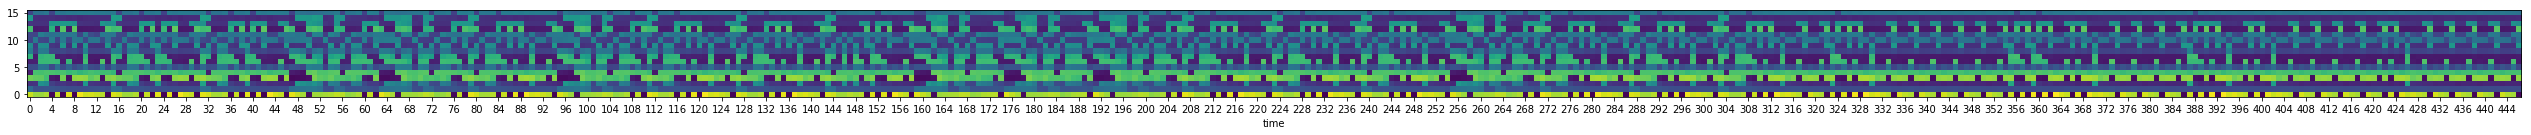

0.630862  mean for last:  0.653472


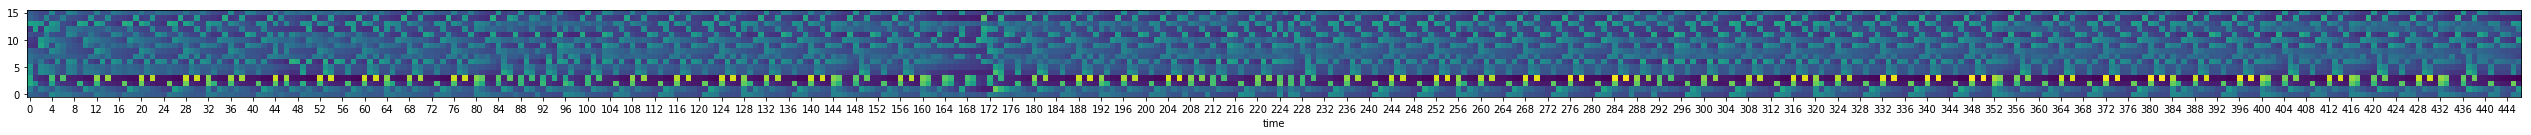

0.622402  mean for last:  0.629993


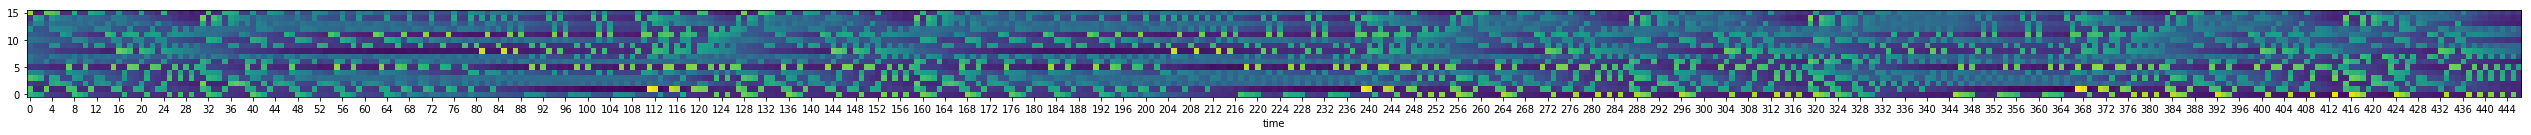

0.619162  mean for last:  0.621782


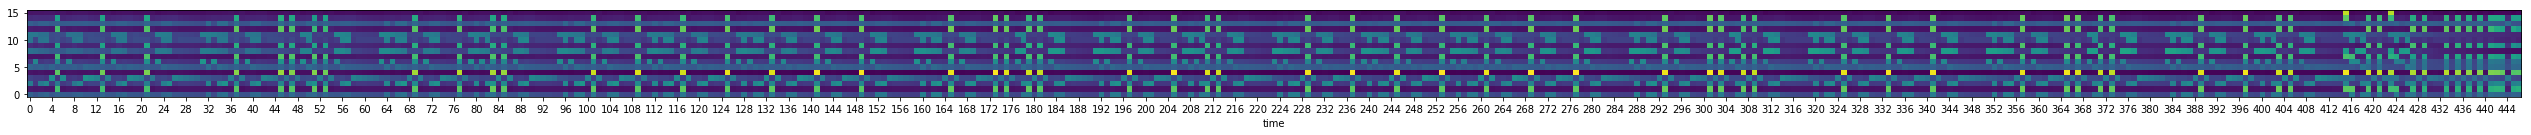

0.614269  mean for last:  0.61918


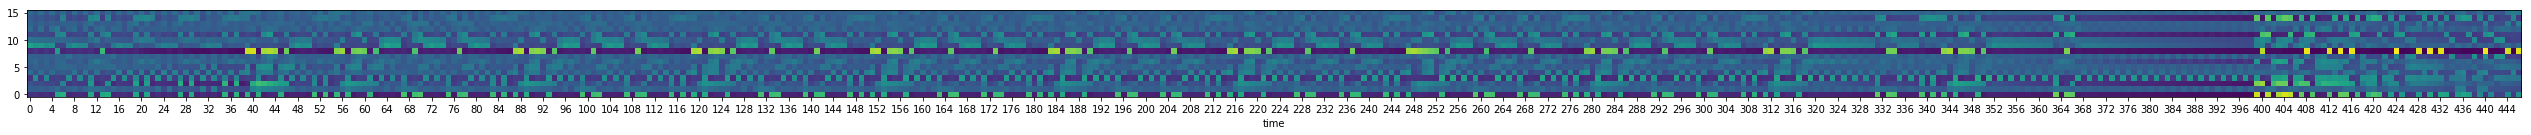

0.610381  mean for last:  0.616591


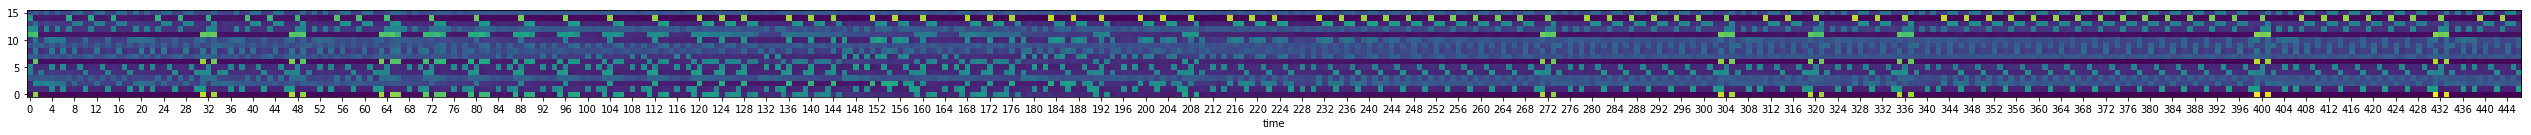

KeyboardInterrupt: 

In [171]:
training_steps = 5000
display_step = 25

losses = []
for step in range(training_steps + 1):
    # getting data
    batch_x, _ = generate()
    # Run optimization step
    sess.run(train_op, feed_dict={X: batch_x})
    
    L = sess.run(ce, feed_dict={X: batch_x})
    losses.append(L.mean())
    
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0])

print("Optimization Finished!")

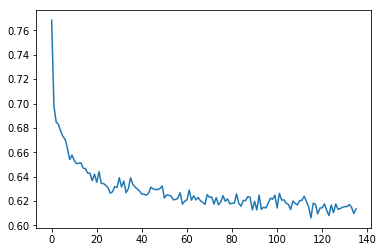

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)

In [173]:
batch_x, P = generate()

In [174]:
probas = sess.run(tf.sigmoid(ans), feed_dict={X: batch_x})

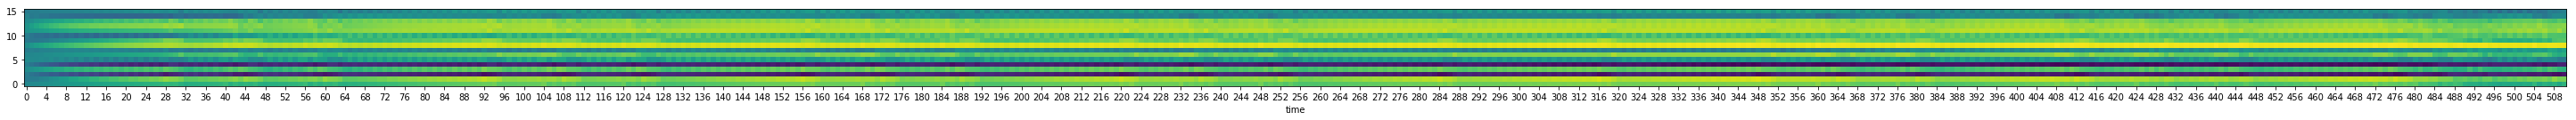

In [175]:
drawNotes(probas[8])

In [176]:
gen = songs[79][:16]

NameError: name 'songs' is not defined

In [42]:
while len(gen) < 128:
    probas = sess.run(tf.sigmoid(ans), feed_dict={X: np.repeat(transform(gen)[None], 125, axis=0)})

    res = np.random.uniform(0, 1, 88) < probas[0, -1]
    gen = np.vstack([gen, res])
    
    print('|', end="")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

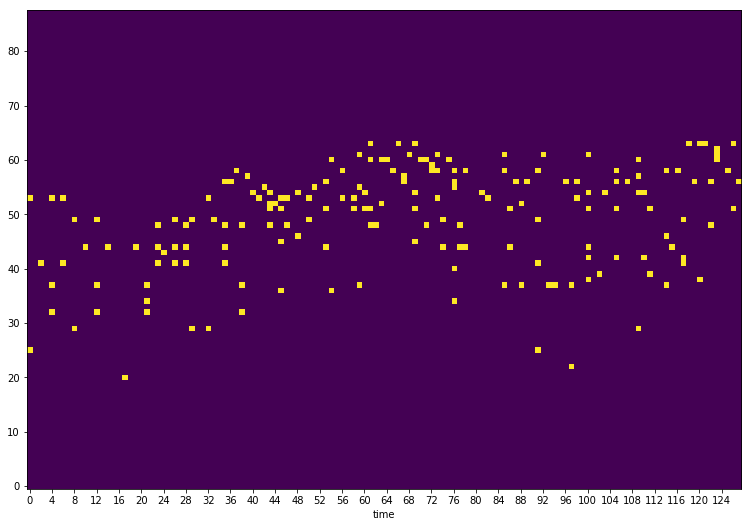

In [43]:
drawNotes(gen)

In [54]:
ms = MySong(gen, finished=True)

In [55]:
ms.play()

KeyboardInterrupt: 

In [57]:
ms.save_file("300 LSTM CM_dataset songs by fragments 8-history 12000 steps lr=0.01")

In [46]:
saver = tf.train.Saver()
saver.save(sess, "./tmp/300 LSTM CM_dataset songs by fragments 8-history 12000 steps lr=0.01.ckpt")

'./tmp/300 LSTM CM_dataset songs by fragments 8-history 12000 steps lr=0.01.ckpt'